## Курсовой проект

__Тема:__ Прогноз ишемической болезни сердца

__Задачи:__
1. Определить какие факторы больше всего влияют на появление ишемической болезни сердца.
2. Определить, есть ли зависимость между курением и риском ишемической болезни сердца.
3. Построить модель логистической регрессии.

__Датасет:__

Для анализа используется датасет https://www.kaggle.com/amanajmera1/framingham-heart-study-dataset


Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти номер 1 во всем мире, ежегодно умирает около 17,9 миллионов людей, что составляет 31% всех смертей в мире.

Этот набор данных содержит 15 факторов, которые можно использовать для прогнозирования риска появления ишемической болезни сердца.


Каждый атрибут является потенциальным фактором риска. Существуют как демографические, так и поведенческие и медицинские факторы риска.

Демографические: 

   __male__: мужской -1, женский - 0

   __age__: возраст пациента


Поведенческие:

__currentSmoker__: является ли пациент курильщиком в настоящее время

__cigsPerDay__: количество сигарет, которое человек выкуривает в среднем за один день

Медицинские (история болезни):

__BPMeds__: принимал ли пациент лекарства от артериального давления

__prevalentStroke__: был ли у пациента ранее инсульт

__prevalentHyp__: наличие у пациента гипертонии

__diabetes__: был ли у пациента диабет

Медицинский (текущие):

__totChol__: уровень общего холестерина

__sysBP__: систолическое артериальное давление

__diaBP__: диастолическое артериальное давление

__BMI__: индекс массы тела

__heartRate__: частота сердечных сокращений

__glucose__: уровень глюкозы 

Прогнозируемая переменная:

__TenYearCHD__:  риск появления ишемической болезни сердца ИБС в течении следующих 10 лет (1 означает «Да», 0 означает «Нет»)

__Подключение библиотек__

In [6]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
#Путь к файлу

DATASET_PATH = 'heart/framingham.csv'

In [8]:
df = pd.read_csv(DATASET_PATH)
display(df)
print(df.shape)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0
4237,0,52,2.0,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0


(4240, 16)


In [9]:
# Посчитаем количество строк с неопределенными значениями
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [10]:
count=0
for i in df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Общее количество строк с пропущеными значениями ', count)
print('это только',round((count/len(df.index))*100), '% из датасета не имеет значений.')

Общее количество строк с пропущеными значениями  582
это только 14 % из датасета не имеет значений.


In [11]:
# Заменим на медиану, неопределенные значения для более точной модели 

df.loc[df['glucose'].isnull(), 'glucose'] = df['glucose'].median()
df.loc[df['BPMeds'].isnull(), 'BPMeds'] = df['BPMeds'].median()
df.loc[df['BMI'].isnull(), 'BMI'] = df['BMI'].median()
df.loc[df['heartRate'].isnull(), 'heartRate'] = df['heartRate'].median()
df.loc[df['cigsPerDay'].isnull(), 'cigsPerDay'] = df['cigsPerDay'].median()
df.loc[df['totChol'].isnull(), 'totChol'] = df['totChol'].median()
df.loc[df['education'].isnull(), 'education'] = df['education'].median()

In [12]:
#Посмотрим значения
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000
mean,0.429245,49.580189,1.979953,0.494104,8.944340,0.029245,0.005896,0.310613,0.025708,236.667689,132.354599,82.897759,25.799005,75.878774,81.600943,0.151887
std,0.495027,8.572942,1.007087,0.500024,11.904777,0.168513,0.076569,0.462799,0.158280,44.328480,22.033300,11.910394,4.070775,12.023937,22.860340,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.077500,68.000000,72.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,144.000000,90.000000,28.032500,83.000000,85.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


__Вычислим попарную корреляцию столбцов__

In [13]:
corr = df.corr()
corr.style.background_gradient()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
male,1.000000,-0.029014,0.017265,0.197026,0.314849,-0.051544,-0.004550,0.005853,0.015693,-0.069643,-0.035879,0.058199,0.081852,-0.116933,0.009970,0.088374
age,-0.029014,1.000000,-0.164016,-0.213662,-0.192017,0.121011,0.057679,0.306799,0.101314,0.260527,0.394053,0.205586,0.135470,-0.012868,0.117878,0.225408
education,0.017265,-0.164016,1.000000,0.018270,0.007856,-0.010445,-0.035178,-0.080780,-0.038204,-0.022851,-0.128139,-0.061326,-0.135744,-0.053658,-0.034090,-0.053570
currentSmoker,0.197026,-0.213662,0.018270,1.000000,0.760326,-0.048348,-0.032980,-0.103710,-0.044285,-0.046391,-0.130281,-0.107933,-0.167368,0.062661,-0.055082,0.019448
cigsPerDay,0.314849,-0.192017,0.007856,0.760326,1.000000,-0.044697,-0.032248,-0.065541,-0.036173,-0.027134,-0.088393,-0.056768,-0.092647,0.074258,-0.056792,0.058729
BPMeds,-0.051544,0.121011,-0.010445,-0.048348,-0.044697,1.000000,0.114614,0.258580,0.051407,0.078642,0.251479,0.192254,0.099617,0.015139,0.049142,0.086448
prevalentStroke,-0.004550,0.057679,-0.035178,-0.032980,-0.032248,0.114614,1.000000,0.074791,0.006955,0.000160,0.057000,0.045153,0.024283,-0.017672,0.018730,0.061823
prevalentHyp,0.005853,0.306799,-0.080780,-0.103710,-0.065541,0.258580,0.074791,1.000000,0.077752,0.162696,0.696656,0.615840,0.300537,0.146751,0.083406,0.177458
diabetes,0.015693,0.101314,-0.038204,-0.044285,-0.036173,0.051407,0.006955,0.077752,1.000000,0.040186,0.111265,0.050260,0.086058,0.048989,0.606495,0.097344
totChol,-0.069643,0.260527,-0.022851,-0.046391,-0.027134,0.078642,0.000160,0.162696,0.040186,1.000000,0.207350,0.163408,0.115035,0.090541,0.045677,0.081749


__Видим сильную корреляцию между:__ 

currentSmoker и cigsPerDay

sysBP и prevalentHyp

glucose и diabetes

sysBP и diaBP

__Построим диаграммы распределения по каждому фактору__

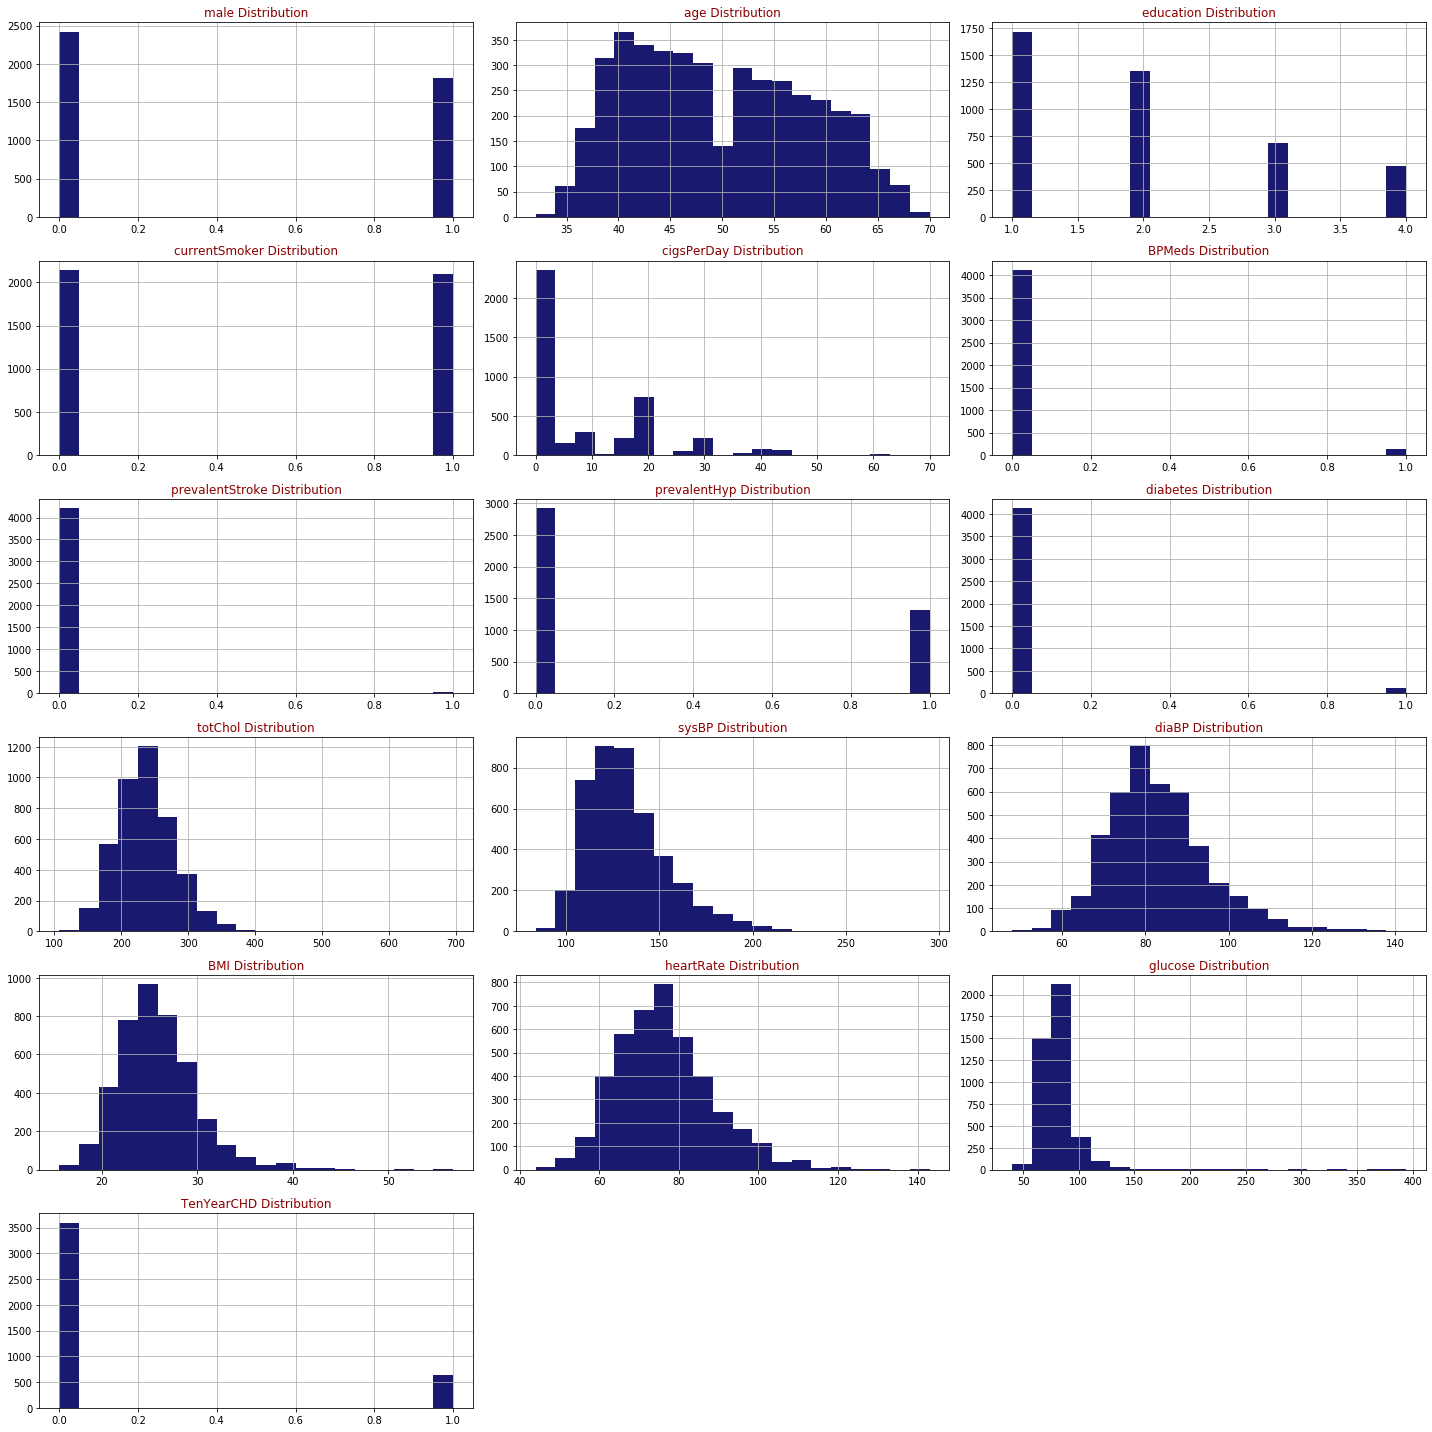

In [14]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(df,df.columns,6,3)

In [15]:
# Посчитаем количество здоровых людей и с заболеванием сердца
df.TenYearCHD.value_counts()

0    3596
1     644
Name: TenYearCHD, dtype: int64

__3596 здоровых людей и 644 с риском заболевания сердца__

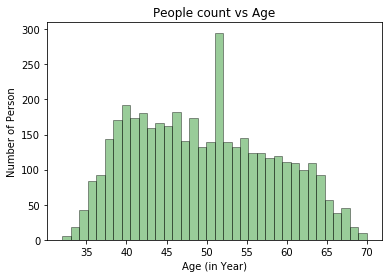

In [25]:
# Посмотрим распределение по возрасту в выборке в отношении к количетству людей
import seaborn as sns

#Seaborn histogram

age = sns.distplot(df['age'], hist = True, kde = False, 
            bins = int (180/5), color = 'green',
            hist_kws = {'edgecolor':'black'}).set(title='People count vs Age', xlabel='Age (in Year)', ylabel='Number of Person')

Видим, что людей до 55 больше, что соответствует большему количеству здоровых людей.

In [64]:
# количество мужчин и женцин. Мужчины = 1, женщины =0
objects = df["male"].value_counts()
print(objects)

# распределение мужчин и женцин среди заболевших
y = df.loc[df['TenYearCHD'] != 0]
objects1 =y["male"].value_counts()
print(objects1)

0.0    2420
1.0    1820
Name: male, dtype: int64
1.0    343
0.0    301
Name: male, dtype: int64


Видим, что среди людей с риском заболевания больше мужчин

### Логистическая регрессия

In [27]:
y = df["TenYearCHD"]
X = df.drop('TenYearCHD',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report

m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

#Оценка модели логистической регрессии

lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

confussion matrix
[[720   2]
 [116  10]]


Accuracy of Logistic Regression: 86.08490566037736 

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       722
           1       0.83      0.08      0.14       126

    accuracy                           0.86       848
   macro avg       0.85      0.54      0.53       848
weighted avg       0.86      0.86      0.81       848



Точность модели 86%

__Посмотрим результат логистической регресси с помощью библиотеки statsmodels.api__

In [23]:
from statsmodels.tools import add_constant as add_constant
# Добавим столбец «фиктивного» фактора:
df_constant = add_constant(df)
df_constant.head()

,const,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [22]:
import statsmodels.api as sm
import scipy.stats as st


st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
cols=df_constant.columns[:-1]
model=sm.Logit(df.TenYearCHD,df_constant[cols])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.378434
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4240
Model:                          Logit   Df Residuals:                     4224
Method:                           MLE   Df Model:                           15
Date:                Wed, 04 Nov 2020   Pseudo R-squ.:                  0.1116
Time:                        22:56:46   Log-Likelihood:                -1604.6
converged:                       True   LL-Null:                       -1806.1
Covariance Type:            nonrobust   LLR p-value:                 1.550e-76
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.1203      0.665    -12.209      0.000      -9.424      -6.817
male                0.5032      0.100      5.013      0.000       0.306       0.700
age                 0.0622      0.006     10.002      0.000       0.050       0.074
education          -0.0134      0.046     -0.289      0.772      -0.104       0.077
currentSmoker       0.0139      0.143      0.098      0.922      -0.266       0.294
cigsPerDay          0.0214      0.006      3.790      0.000       0.010       0.032
BPMeds              0.2438      0.220      1.107      0.268      -0.188       0.675
prevalentStroke     0.9613      0.442      2.177      0.030       0.096       1.827
prevalentHyp        0.2303      0.128      1.793      0.073      -0.021       0.482
diabetes            0.1878      0.294      0.638      0.523      -0.389       0.765
totChol             0.0018      0.001      1.788      0.074      -0.000       0.004
sysBP               0.0141      0.004      3.984      0.000       0.007       0.021
diaBP              -0.0029      0.006     -0.478      0.633      -0.015       0.009
BMI                 0.0032      0.012      0.269      0.788      -0.020       0.026
heartRate          -0.0015      0.004     -0.384      0.701      -0.009       0.006
glucose             0.0067      0.002      3.135      0.002       0.003       0.011
===================================================================================
"""

Приведенные выше результаты показывают, что некоторые атрибуты со значением P выше, чем предпочтительный альфа (5%) и, таким образом, демонстрируют низкую статистически значимую связь с вероятностью сердечного заболевания.

Статистически значемыми являются факторы: 

__male__ пол

__age__ возраст

__cigsPerDay__ количество, сигарет день

__prevalentStroke__ наличие инфаркта в прошлом

__sysBP__  систолическое артериальное давление

__glucose__ уровень глюкозы